# Chapter 2 – End-to-end Machine Learning project

Welcome to Machine Learning Housing Corp.! Your task is to predict median house values in Californian districts, given a number of features from these districts.

This notebook contains all the sample code and solutions to the exercices in chapter 2.

->  ***It is a typical regression task, this is a multiple regression problem, since the system will use multiple features to make a prediction, and the data is small enough to fit in memory, so plain batch learning should do just fine.***

---
## Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.



In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


## Get the Data
### Download the Data


In [2]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
fetch_housing_data()

In [4]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

## Take a Quick Look at the Data Structure

In [5]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
housing.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [8]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

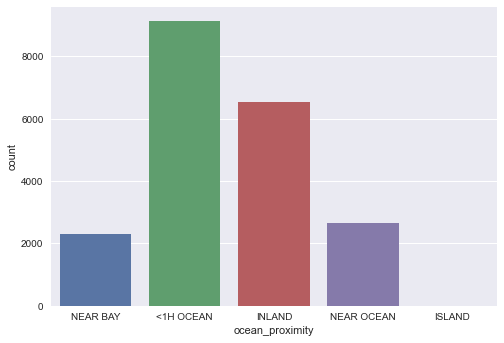

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')     # switch to seaborn style
import seaborn as sns

sns.countplot(data=housing, x="ocean_proximity");

In [11]:
# the null values are ignored
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Saving figure attribute_histogram_plots


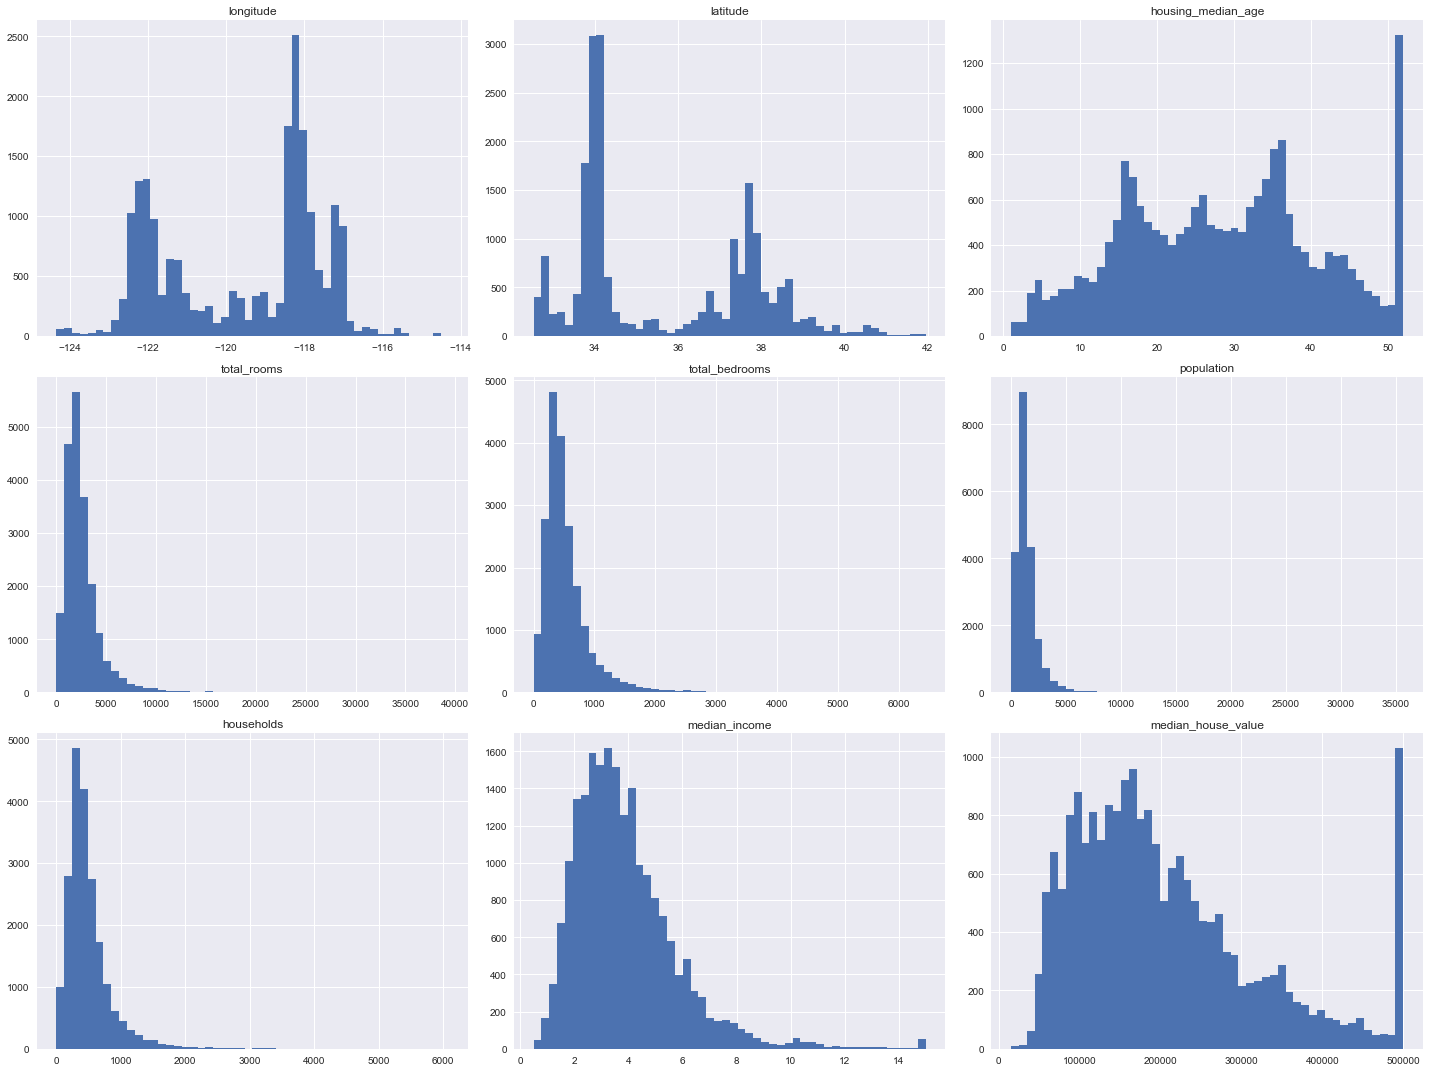

In [12]:
housing.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

- The housing median age and the median house value were also capped.
- These attributes have very different scales.
- they extend much farther to the right of the median than to the left.

## Create a Test Set

your brain is an amazing pattern detection system

In [13]:
# to make this notebook's output identical at every run
np.random.seed(42)

In [14]:
import numpy as np

# For illustration only. Sklearn has train_test_split()
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [15]:
train_set, test_set = split_train_test(housing, 0.2)
len(train_set)

16512

In [16]:
len(test_set)

4128

In [17]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

The implementation of `test_set_check()` above works fine in both Python 2 and Python 3. In earlier releases, the following implementation was proposed, which supported any hash function, but was much slower and did not support Python 2:



In [18]:
import hashlib

def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

If you want an implementation that supports any hash function and is compatible with both Python 2 and Python 3, here is one:

In [19]:
def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return bytearray(hash(np.int64(identifier)).digest())[-1] < 256 * test_ratio

In [20]:
housing_with_id = housing.reset_index()   # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [21]:
# use the most stable features to build a unique identifier
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [22]:
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
8,8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY,-122222.16
10,10,-122.26,37.85,52.0,2202.0,434.0,910.0,402.0,3.2031,281500.0,NEAR BAY,-122222.15
11,11,-122.26,37.85,52.0,3503.0,752.0,1504.0,734.0,3.2705,241800.0,NEAR BAY,-122222.15
12,12,-122.26,37.85,52.0,2491.0,474.0,1098.0,468.0,3.0750,213500.0,NEAR BAY,-122222.15
13,13,-122.26,37.84,52.0,696.0,191.0,345.0,174.0,2.6736,191300.0,NEAR BAY,-122222.16


In [23]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [24]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


#### It is important to have a sufficient number of instances in your dataset for each stratum

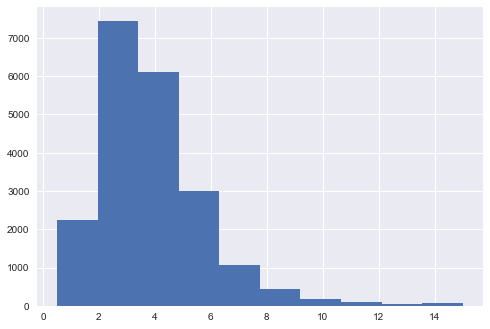

In [25]:
housing["median_income"].hist();

In [26]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [27]:
housing["income_cat"].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

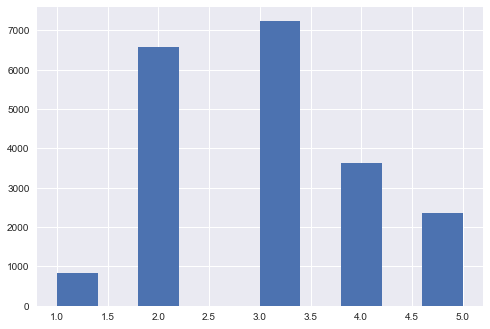

In [28]:
housing["income_cat"].hist();

In [29]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [30]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [31]:
housing["income_cat"].value_counts() / len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

the test set generated using stratified sampling has income category proportions almost identical to those in the full dataset

In [32]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [33]:
import pprint

pprint.pprint(compare_props)

    Overall  Stratified    Random  Rand. %error  Strat. %error
1  0.039826    0.039971  0.040213      0.973236       0.364964
2  0.318847    0.318798  0.324370      1.732260      -0.015195
3  0.350581    0.350533  0.358527      2.266446      -0.013820
4  0.176308    0.176357  0.167393     -5.056334       0.027480
5  0.114438    0.114341  0.109496     -4.318374      -0.084674


In [34]:
# you should remove the income_cat attribute so the data is back to its original state
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

---
## Discover and Visualize the Data to Gain Insights

In [35]:
housing = strat_train_set.copy()

### Visualizing Geographical Data


Saving figure bad_visualization_plot


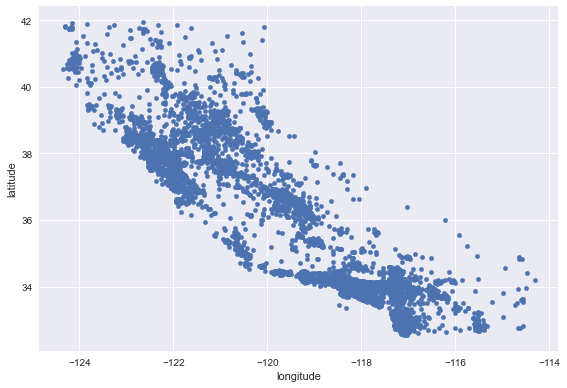

In [36]:
housing.plot(kind="scatter", x="longitude", y="latitude")
save_fig("bad_visualization_plot");

Saving figure better_visualization_plot


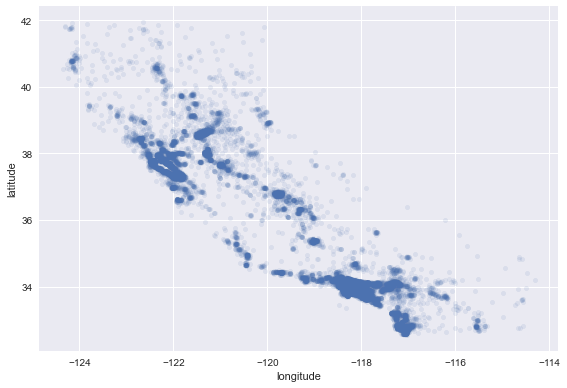

In [37]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
save_fig("better_visualization_plot")

The argument `sharex=False` fixes a display bug (the x-axis values and legend were not displayed). This is a temporary fix (see: https://github.com/pandas-dev/pandas/issues/10611 ). Thanks to Wilmer Arellano for pointing it out.



Saving figure housing_prices_scatterplot


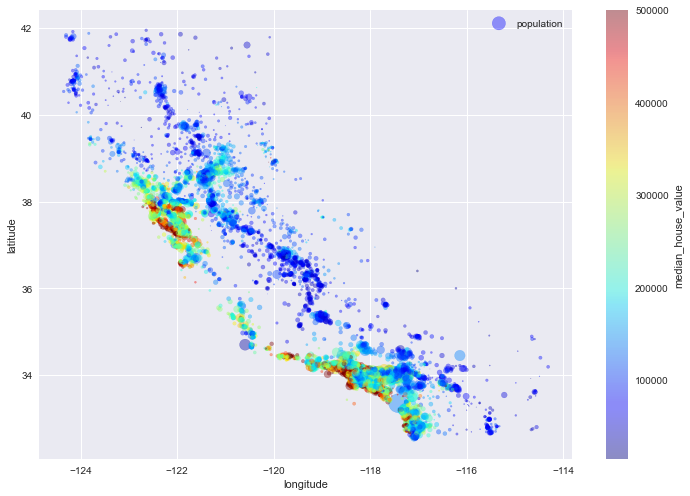

In [38]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="population", figsize=(10,7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)
plt.legend()
save_fig("housing_prices_scatterplot")

In [39]:
# Download the California image
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "end_to_end_project")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "california.png"
print("Downloading", filename, '.....')
url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('.\\images\\end_to_end_project\\california.png',
 <http.client.HTTPMessage at 0x13059e8e7c0>)

C:\Users\mahmo\AppData\Local\Temp/ipykernel_880/3912764189.py:14: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(ticks=tick_values/prices.max())


Saving figure california_housing_prices_plot


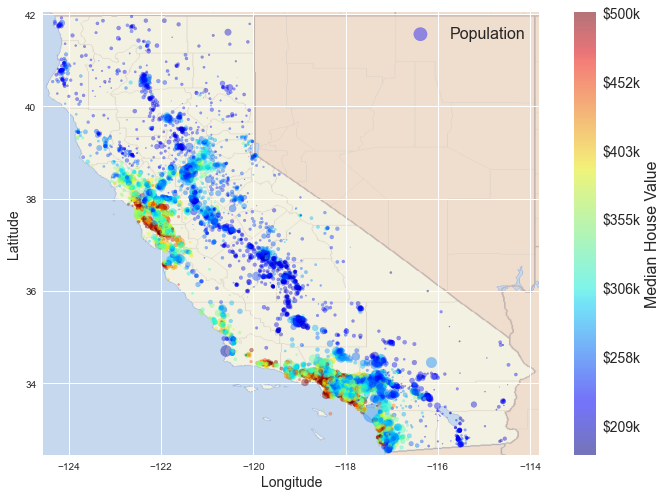

In [40]:
import matplotlib.image as mpimg
california_img=mpimg.imread(os.path.join(images_path, filename))
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                  s=housing['population']/100, label="Population",
                  c="median_house_value", cmap=plt.get_cmap("jet"),
                  colorbar=False, alpha=0.4)
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar(ticks=tick_values/prices.max())
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
save_fig("california_housing_prices_plot")
plt.show()

### Looking for Correlations

Since the dataset is not too large, you can easily compute the standard correlation coef icient (also called Pearson’s r) between every pair of attributes using the `corr()` method:

In [41]:
corr_matrix = housing.corr()

In [42]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

Saving figure scatter_matrix_plot


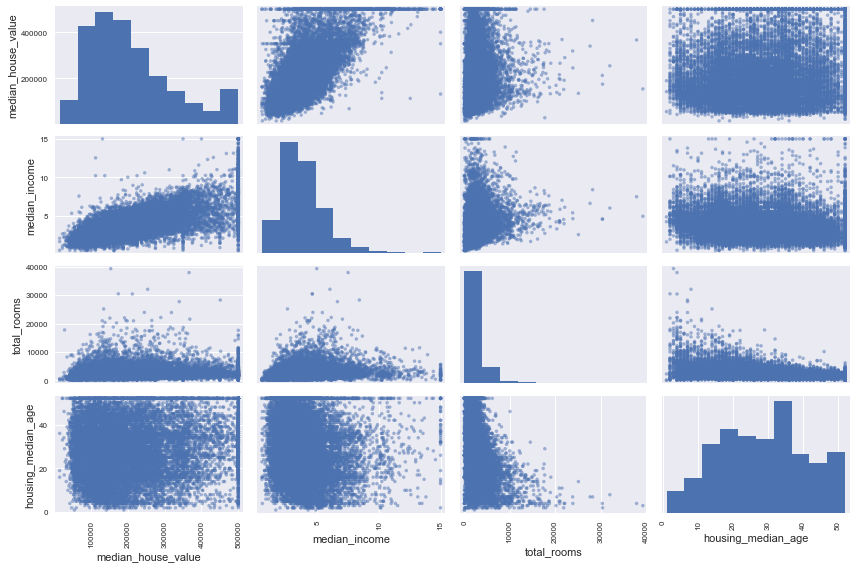

In [43]:
# from pandas.tools.plotting import scatter_matrix # For older versions of Pandas
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

Saving figure income_vs_house_value_scatterplot


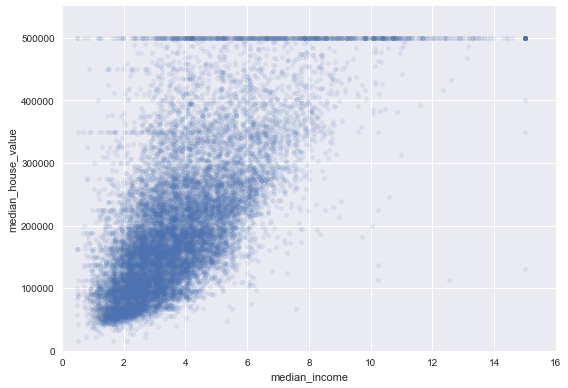

In [44]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])
save_fig("income_vs_house_value_scatterplot")

You may want to try removing the corresponding districts to prevent your algorithms from learning to reproduce these data quirks.

### Experimenting with Attribute Combinations

One last thing you may want to do before preparing the data for Machine Learning algorithms is to try out various attribute combinations.

In [45]:
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

In [46]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [47]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

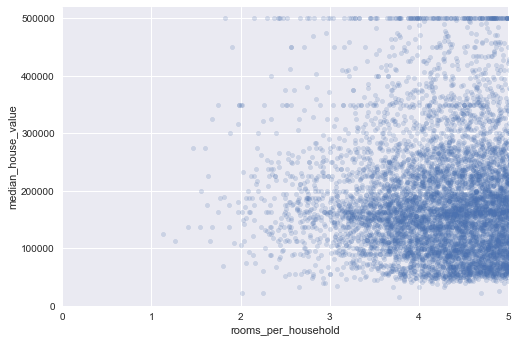

In [48]:
housing.plot(kind="scatter", x="rooms_per_household", y="median_house_value",
             alpha=0.2)
plt.axis([0, 5, 0, 520000])
plt.show()

In [49]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000
mean,-119.575635,35.639314,28.653404,2622.539789,534.914639,1419.687379,497.011810,3.875884,207005.322372,5.440406,0.212873,3.096469
std,2.001828,2.137963,12.574819,2138.417080,412.665649,1115.663036,375.696156,1.904931,115701.297250,2.611696,0.057378,11.584825
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,14999.000000,1.130435,0.100000,0.692308
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566950,119800.000000,4.442168,0.175304,2.431352
50%,-118.510000,34.260000,29.000000,2119.000000,433.000000,1164.000000,408.000000,3.541550,179500.000000,5.232342,0.203027,2.817661
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.000000,602.000000,4.745325,263900.000000,6.056361,0.239816,3.281420
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000,141.909091,1.000000,1243.333333


---
## Prepare the Data for Machine Learning Algorithms

In [50]:
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

### Data Cleaning

In the book 3 options are listed:
```python
housing.dropna(subset=["total_bedrooms"])    # option 1 - Get rid of the corresponding districts.
housing.drop("total_bedrooms", axis=1)       # option 2 - Get rid of the whole attribute.
median = housing["total_bedrooms"].median()  # option 3 - Set the values to some value (ex: median)
housing["total_bedrooms"].fillna(median, inplace=True)
```

To demonstrate each of them, let's create a copy of the housing dataset, but keeping only the rows that contain at least one null. Then it will be easier to visualize exactly what each option does:



In [51]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,NaN,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,NaN,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,NaN,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,NaN,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,NaN,1145.0,480.0,6.3580,NEAR OCEAN


In [52]:
sample_incomplete_rows.dropna(subset=["total_bedrooms"])    # option 1

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [53]:
sample_incomplete_rows.drop("total_bedrooms", axis=1)       # option 2

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,1145.0,480.0,6.3580,NEAR OCEAN


In [54]:
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # option 3

sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,433.0,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,433.0,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,433.0,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,433.0,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,433.0,1145.0,480.0,6.3580,NEAR OCEAN


In [55]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

Remove the text attribute because median can only be calculated on numerical attributes:



In [56]:
housing_num = housing.drop("ocean_proximity", axis=1)
# alternatively: housing_num = housing.select_dtypes(include=[np.number])

In [57]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [58]:
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [59]:
housing_num.median().values

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

Transform the training set:



In [60]:
X = imputer.transform(housing_num)

The result is a plain NumPy array containing the transformed features. 

In [61]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing.index)

housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
1606,-122.08,37.88,26.0,2947.0,433.0,825.0,626.0,2.9330
10915,-117.87,33.73,45.0,2264.0,433.0,1970.0,499.0,3.4193
19150,-122.70,38.35,14.0,2313.0,433.0,954.0,397.0,3.7813
4186,-118.23,34.13,48.0,1308.0,433.0,835.0,294.0,4.2891
16885,-122.40,37.58,26.0,3281.0,433.0,1145.0,480.0,6.3580


In [62]:
imputer.strategy

'median'

In [63]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964


### Handling Text and Categorical Attributes

Now let's preprocess the categorical input feature, `ocean_proximity`:

In [64]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


In [65]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

One issue with this representation is that ML algorithms will assume that two nearby values are more similar than two distant values.

In [66]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [67]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

By default, the `OneHotEncoder` class returns a ***sparse array***, but we can convert it to a dense array if needed by calling the `toarray()` method:



In [68]:
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

Alternatively, you can set `sparse=False` when creating the `OneHotEncoder`:



In [69]:
cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [70]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### Custom Transformers

Although Scikit-Learn provides many useful transformers, you will need to write your own for tasks such as custom cleanup operations or combining specific attributes.
Since Scikit-Learn relies on duck typing (not inheritance), all you need to do is create a class and implement three methods:  
1. `fit()` (returning self)  
2. `transform()`   
3. `fit_transform()`.  

Let's create a custom transformer to add extra attributes:

In [71]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

Note that I hard coded the indices (3, 4, 5, 6) for concision and clarity in the book, but it would be much cleaner to get them dynamically, like this:



In [72]:
col_names = "total_rooms", "total_bedrooms", "population", "households"
rooms_ix, bedrooms_ix, population_ix, households_ix = [
    housing.columns.get_loc(c) for c in col_names] # get the column indices

Also, `housing_extra_attribs` is a NumPy array, we've lost the column names (unfortunately, that's a problem with Scikit-Learn). To recover a `DataFrame`, you could run this:



In [73]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND,5.485836,3.168555
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,NEAR OCEAN,6.927083,2.623698
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.875,INLAND,5.393333,2.223333
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,NEAR OCEAN,3.886128,1.859213
20496,-118.7,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,<1H OCEAN,6.096552,3.167241


### Transformation Pipelines
Now let's build a pipeline for preprocessing the numerical attributes:


In [74]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

housing_num_tr

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.01739526,
         0.00622264, -0.12112176],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.56925554,
        -0.04081077, -0.81086696],
       [ 0.26758118, -0.1259716 ,  1.22045984, ..., -0.01802432,
        -0.07537122, -0.33827252],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ..., -0.5092404 ,
        -0.03743619,  0.32286937],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.32814891,
        -0.05915604, -0.45702273],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.01407228,
         0.00657083, -0.12169672]])

In [75]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

housing_prepared

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ...,  0.        ,
         0.        ,  0.        ],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.        ,
         0.        ,  0.        ]])

In [76]:
housing_prepared.shape

(16512, 16)

For reference, here is the old solution based on a `DataFrameSelector` transformer (to just select a subset of the Pandas `DataFrame` columns), and a `FeatureUnion`:



In [77]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
class OldDataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

Now let's join all these components into a big pipeline that will preprocess both the numerical and the categorical features:

It would be more convenient to have a single transformer able to
handle all columns, applying the appropriate transformations to each column.

In [78]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

old_num_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

old_cat_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder(sparse=False)),
    ])

In [79]:
from sklearn.pipeline import FeatureUnion

old_full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", old_num_pipeline),
        ("cat_pipeline", old_cat_pipeline),
    ])

In [80]:
old_housing_prepared = old_full_pipeline.fit_transform(housing)
old_housing_prepared

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ...,  0.        ,
         0.        ,  0.        ],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.        ,
         0.        ,  0.        ]])

The result is the same as with the `ColumnTransformer`:



In [81]:
np.allclose(housing_prepared, old_housing_prepared)

True

## Select and Train a Model

### Training and Evaluating on the Training Set


In [82]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [83]:
# let's try the full preprocessing pipeline on a few training instances
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089]


In [84]:
print("Labels:", list(some_labels))

Labels: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [85]:
some_data_prepared

array([[-0.94135046,  1.34743822,  0.02756357,  0.58477745,  0.64037127,
         0.73260236,  0.55628602, -0.8936472 ,  0.01739526,  0.00622264,
        -0.12112176,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.17178212, -1.19243966, -1.72201763,  1.26146668,  0.78156132,
         0.53361152,  0.72131799,  1.292168  ,  0.56925554, -0.04081077,
        -0.81086696,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, -0.46977281, -0.54513828,
        -0.67467519, -0.52440722, -0.52543365, -0.01802432, -0.07537122,
        -0.33827252,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.22173797, -1.35147437, -0.37006852, -0.34865152, -0.03636724,
        -0.46761716, -0.03729672, -0.86592882, -0.59513997, -0.10680295,
         0.96120521,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [ 0.43743108, -0.63581817, -0

In [86]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68627.87390018745

This is an example of a model underfitting the training data.


**Note**: since Scikit-Learn 0.22, you can get the RMSE directly by calling the `mean_squared_error()` function with `squared=False`.

In [87]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49438.66860915801

In [88]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(random_state=42)

In [89]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

the model has badly overfit the data.


### Better Evaluation Using Cross-Validation

In [90]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
# Scikit-Learn’s cross-validation features expect a utility function 
# (greater is better) rather than a cost function (lower is better)
tree_rmse_scores = np.sqrt(-scores)

**cross-validation** allows you to get not only an estimate of the performance of your
model, but also a measure of how precise this estimate is (i.e., its standard
deviation). 

In [91]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [72831.45749112 69973.18438322 69528.56551415 72517.78229792
 69145.50006909 79094.74123727 68960.045444   73344.50225684
 69826.02473916 71077.09753998]
Mean: 71629.89009727491
Standard deviation: 2914.035468468928


In [92]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean: 69104.07998247063
Standard deviation: 2880.3282098180603


**Note**: we specify `n_estimators=100` to be future-proof since the default value is going to change to 100 in Scikit-Learn 0.22 (for simplicity, this is not shown in the book).



In [93]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(random_state=42)

In [94]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18650.698705770003

In [95]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [51559.63379638 48737.57100062 47210.51269766 51875.21247297
 47577.50470123 51863.27467888 52746.34645573 50065.1762751
 48664.66818196 54055.90894609]
Mean: 50435.58092066179
Standard deviation: 2203.3381412764606


In [96]:
pd.Series(forest_rmse_scores).describe()

count       10.000000
mean     50435.580921
std       2322.522327
min      47210.512698
25%      48682.893887
50%      50812.405036
75%      51872.228024
max      54055.908946
dtype: float64

In [97]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

count       10.000000
mean     69104.079982
std       3036.132517
min      64114.991664
25%      67077.398482
50%      68718.763507
75%      71357.022543
max      73997.080502
dtype: float64

In [98]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)

svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

111095.06635291968

## Fine-Tune Your Model

### Grid Search


In [99]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [100]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [101]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30, random_state=42)

Let's look at the score of each hyperparameter combination tested during the grid search:



In [102]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63895.161577951665 {'max_features': 2, 'n_estimators': 3}
54916.32386349543 {'max_features': 2, 'n_estimators': 10}
52885.86715332332 {'max_features': 2, 'n_estimators': 30}
60075.3680329983 {'max_features': 4, 'n_estimators': 3}
52495.01284985185 {'max_features': 4, 'n_estimators': 10}
50187.24324926565 {'max_features': 4, 'n_estimators': 30}
58064.73529982314 {'max_features': 6, 'n_estimators': 3}
51519.32062366315 {'max_features': 6, 'n_estimators': 10}
49969.80441627874 {'max_features': 6, 'n_estimators': 30}
58895.824998155826 {'max_features': 8, 'n_estimators': 3}
52459.79624724529 {'max_features': 8, 'n_estimators': 10}
49898.98913455217 {'max_features': 8, 'n_estimators': 30}
62381.765106921855 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54476.57050944266 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59974.60028085155 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52754.5632813202 {'bootstrap': False, 'max_features': 3, 'n_estimators': 1

In [103]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.062474,0.002357,0.003998,0.000004,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-4.119912e+09,-3.723465e+09,...,-4.082592e+09,1.867375e+08,18,-1.155630e+09,-1.089726e+09,-1.153843e+09,-1.118149e+09,-1.093446e+09,-1.122159e+09,2.834288e+07
1,0.202619,0.001722,0.009796,0.000400,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-2.973521e+09,-2.810319e+09,...,-3.015803e+09,1.139808e+08,11,-5.982947e+08,-5.904781e+08,-6.123850e+08,-5.727681e+08,-5.905210e+08,-5.928894e+08,1.284978e+07
2,0.609172,0.001414,0.026896,0.000184,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-2.801229e+09,-2.671474e+09,...,-2.796915e+09,7.980892e+07,9,-4.412567e+08,-4.326398e+08,-4.553722e+08,-4.320746e+08,-4.311606e+08,-4.385008e+08,9.184397e+06
3,0.097953,0.001672,0.003598,0.000489,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-3.528743e+09,-3.490303e+09,...,-3.609050e+09,1.375683e+08,16,-9.782368e+08,-9.806455e+08,-1.003780e+09,-1.016515e+09,-1.011270e+09,-9.980896e+08,1.577372e+07
4,0.317782,0.002168,0.009397,0.000491,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-2.742620e+09,-2.609311e+09,...,-2.755726e+09,1.182604e+08,7,-5.063215e+08,-5.257983e+08,-5.081984e+08,-5.174405e+08,-5.282066e+08,-5.171931e+08,8.882622e+06
5,0.943125,0.005284,0.026499,0.000448,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-2.522176e+09,-2.440241e+09,...,-2.518759e+09,8.488084e+07,3,-3.776568e+08,-3.902106e+08,-3.885042e+08,-3.830866e+08,-3.894779e+08,-3.857872e+08,4.774229e+06
6,0.125050,0.001621,0.003398,0.000490,6,3,NaN,"{'max_features': 6, 'n_estimators': 3}",-3.362127e+09,-3.311863e+09,...,-3.371513e+09,1.378086e+08,13,-8.909397e+08,-9.583733e+08,-9.000201e+08,-8.964731e+08,-9.151927e+08,-9.121998e+08,2.444837e+07
7,0.420612,0.002850,0.009796,0.000400,6,10,NaN,"{'max_features': 6, 'n_estimators': 10}",-2.622099e+09,-2.669655e+09,...,-2.654240e+09,6.967978e+07,5,-4.939906e+08,-5.145996e+08,-5.023512e+08,-4.959467e+08,-5.147087e+08,-5.043194e+08,8.880106e+06
8,1.329487,0.031144,0.028187,0.002925,6,30,NaN,"{'max_features': 6, 'n_estimators': 30}",-2.446142e+09,-2.446594e+09,...,-2.496981e+09,7.357046e+07,2,-3.760968e+08,-3.876636e+08,-3.875307e+08,-3.760938e+08,-3.861056e+08,-3.826981e+08,5.418747e+06
9,0.166271,0.003222,0.003799,0.000400,8,3,NaN,"{'max_features': 8, 'n_estimators': 3}",-3.590333e+09,-3.232664e+09,...,-3.468718e+09,1.293758e+08,14,-9.505012e+08,-9.166119e+08,-9.033910e+08,-9.070642e+08,-9.459386e+08,-9.247014e+08,1.973471e+07


### Randomized Search

In [104]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000013075038DF0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000130750387C0>},
                   random_state=42, scoring='neg_mean_squared_error')

In [105]:
randint(low=20, high=200)

In [106]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49117.55344336652 {'max_features': 7, 'n_estimators': 180}
51450.63202856348 {'max_features': 5, 'n_estimators': 15}
50692.53588182537 {'max_features': 3, 'n_estimators': 72}
50783.614493515 {'max_features': 5, 'n_estimators': 21}
49162.89877456354 {'max_features': 7, 'n_estimators': 122}
50655.798471042704 {'max_features': 3, 'n_estimators': 75}
50513.856319990606 {'max_features': 3, 'n_estimators': 88}
49521.17201976928 {'max_features': 5, 'n_estimators': 100}
50302.90440763418 {'max_features': 3, 'n_estimators': 150}
65167.02018649492 {'max_features': 5, 'n_estimators': 2}


### Analyze the Best Models and Their Errors


In [107]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([6.96542523e-02, 6.04213840e-02, 4.21882202e-02, 1.52450557e-02,
       1.55545295e-02, 1.58491147e-02, 1.49346552e-02, 3.79009225e-01,
       5.47789150e-02, 1.07031322e-01, 4.82031213e-02, 6.79266007e-03,
       1.65706303e-01, 7.83480660e-05, 1.52473276e-03, 3.02816106e-03])

In [108]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
#cat_encoder = cat_pipeline.named_steps["cat_encoder"] # old solution
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3790092248170967, 'median_income'),
 (0.16570630316895876, 'INLAND'),
 (0.10703132208204355, 'pop_per_hhold'),
 (0.06965425227942929, 'longitude'),
 (0.0604213840080722, 'latitude'),
 (0.054778915018283726, 'rooms_per_hhold'),
 (0.048203121338269206, 'bedrooms_per_room'),
 (0.04218822024391753, 'housing_median_age'),
 (0.01584911474442863, 'population'),
 (0.015554529490469328, 'total_bedrooms'),
 (0.01524505568840977, 'total_rooms'),
 (0.014934655161887772, 'households'),
 (0.006792660074259966, '<1H OCEAN'),
 (0.003028161062896275, 'NEAR OCEAN'),
 (0.0015247327555504935, 'NEAR BAY'),
 (7.834806602687504e-05, 'ISLAND')]

you may want to try dropping some of the less useful
features.

## Evaluate Your System on the Test Set


In [109]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

final_rmse

47873.26095812988

We can compute a 95% confidence interval for the test RMSE:



In [110]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([45893.36082829, 49774.46796717])

We could compute the interval manually like this:

In [111]:
m = len(squared_errors)
mean = squared_errors.mean()
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

(45893.3608282853, 49774.46796717339)

Alternatively, we could use a z-scores rather than t-scores:

In [112]:
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

(45893.954011012866, 49773.92103065016)

## Extra material

### A full pipeline with both preparation and prediction

In [113]:
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinearRegression())
    ])

full_pipeline_with_predictor.fit(housing, housing_labels)
full_pipeline_with_predictor.predict(some_data)

array([ 85657.90192014, 305492.60737488, 152056.46122456, 186095.70946094,
       244550.67966089])

### Model persistence using joblib

In [114]:
my_model = full_pipeline_with_predictor

In [115]:
import joblib
joblib.dump(my_model, "my_model.pkl") # DIFF
#...
my_model_loaded = joblib.load("my_model.pkl") # DIFF

### Example SciPy distributions for `RandomizedSearchCV`


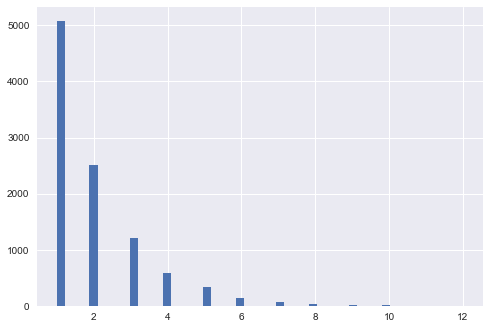

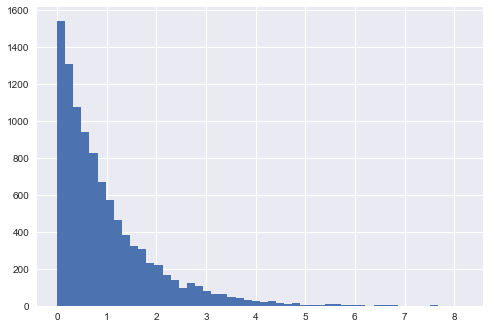

In [116]:
from scipy.stats import geom, expon

geom_distrib=geom(0.5).rvs(10000, random_state=42)
expon_distrib=expon(scale=1).rvs(10000, random_state=42)
plt.hist(geom_distrib, bins=50)
plt.show()
plt.hist(expon_distrib, bins=50)
plt.show()

---
# Exercises:


1. Try a Support Vector Machine regressor `(sklearn.svm.SVR)` with various hyperparameters, such as `kernel="linear"` (with various values for the C hyperparameter) or `kernel="rbf"` (with various values for the `C` and `gamma` hyperparameters). Don’t worry about what these hyperparameters mean for now. How does the best `SVR` predictor perform?

2. Try replacing `GridSearchCV` with `RandomizedSearchCV`.

3. Try adding a transformer in the preparation pipeline to select only the most important attributes.

4. Try creating a single pipeline that does the full data preparation plus the final prediction.

5. Automatically explore some preparation options using `GridSearchCV`.
